# Computational Cost Estimates for Cosmic Explorer

## Amber Lenon<sup>1</sup>, Alexander Nitz<sup>2,3</sup>, and Duncan Brown<sup>1</sup>

**<sup>1</sup> Department of Physics, Syracuse University, Syracuse NY 13224, USA**<br>
**<sup>2</sup> Max-Planck-Institut für Gravitationsphysik, Albert-Einstein-Institut, D-30167 Hannover, Germany**<br>
**<sup>3</sup> Leibniz Universität Hannover, D-30167 Hannover, Germany**

We compare the project computational cost estimates for Cosmic Explorer with those of Advanced LIGO. We find that since the low-frequency seismic wall of Cosmic Explorer is comparable to that of Advanced LIGO, the computational cost of searches for compact object binaries is of the same order of magnitude as that of Advnaced LIGO. Similarly, the cost of parameter estimation for a single event in Cosmic Explorer is comparable to Advanced LIGO and the cost of measuring the parameters of Cosmic Explorer event will not be substantially more expensive that for Advanced LIGO. The overall cost of Cosmic Explorer parameter estimation will scale with the number of events detected. Although the expected event rate will be three orders of magnitude larger than that of Advanced LIGO, the event rate will not be confusion limited. Techinques are available that can perform full parameter estimation of signals within one hour on current hardware resources and so we do not forsee significant computational challenges for Cosmic Explorer data analysis.

### Set up output plot format

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid']=True
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

### Set up data segment length for analysis

In [2]:
td_length = 2048 # seconds
srate = 4096 # Hz
f_low = 3.0 # Hz
N = int(td_length * srate)
fd_length = int(N / 2 + 1)
delta_t = 1.0 / srate
delta_f = 1.0 / td_length

### Read in amplitude spectral density files for each detector

In [3]:
import pycbc.psd

psd_ce1 = pycbc.psd.from_txt('noise-files/CE1_strain.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=3.0, is_asd_file=True)
psd_ce2 = pycbc.psd.from_txt('noise-files/CE2_strain.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=3.0, is_asd_file=True)
psd_etd = pycbc.psd.from_txt('noise-files/ETD_Strain.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=1.0, is_asd_file=True)
psd_aligo = pycbc.psd.analytical.AdVDesignSensitivityP1200087(length=fd_length, delta_f=delta_f, 
                                                              low_freq_cutoff=3.0)

In [4]:
rcParams['figure.figsize']=(14,6)

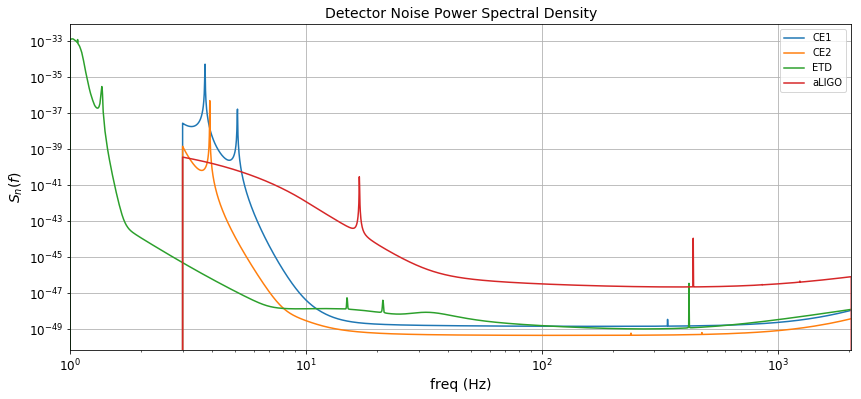

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.loglog(psd_ce1.sample_frequencies, psd_ce1, label = "CE1")
plt.plot(psd_ce2.sample_frequencies, psd_ce2, label = "CE2")
plt.plot(psd_etd.sample_frequencies, psd_etd, label = "ETD")
plt.plot(psd_aligo.sample_frequencies, psd_aligo, label = "aLIGO")
plt.legend()
plt.xlim([1,2048])
plt.xlabel("freq (Hz)")
plt.ylabel(r"$S_n(f)$")
plt.title("Detector Noise Power Spectral Density")
plt.show()

### Generate a BNS waveform

In [6]:
import pycbc.waveform

m1 = m2 = 1.4

sp_tilde, sc_tilde = pycbc.waveform.get_fd_waveform(approximant="TaylorF2", 
                                                    mass1=m1, mass2=m1, delta_f=delta_f, f_lower=f_low)
sp_tilde.resize(fd_length)
sp_sp_ast = np.absolute(sp_tilde.conj()*sp_tilde)

In [7]:
snr_integrand_ce1 = sp_sp_ast / psd_ce1
del psd_ce1

snr_integrand_ce2 = sp_sp_ast / psd_ce2
del psd_ce2

snr_integrand_etd = sp_sp_ast / psd_etd
del psd_etd

snr_integrand_aligo = sp_sp_ast / psd_aligo
del psd_aligo

/usr/lib64/python2.7/site-packages/pycbc/types/array.py:368: RuntimeWarning: invalid value encountered in true_divide
  return self._data / other


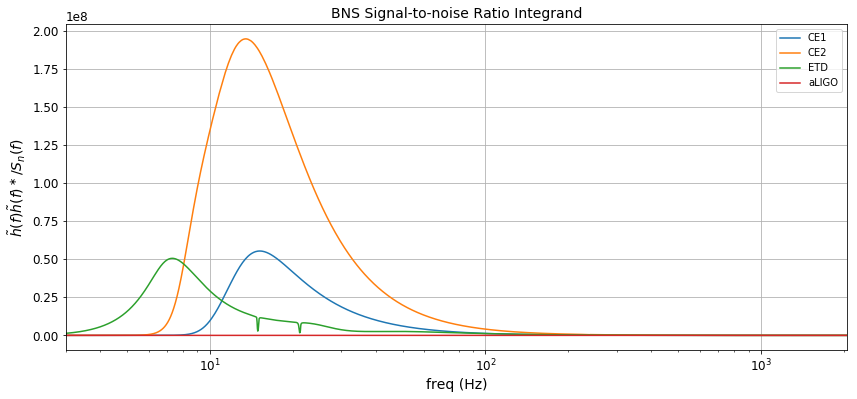

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.semilogx(snr_integrand_ce1.sample_frequencies, snr_integrand_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, snr_integrand_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, snr_integrand_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, snr_integrand_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,2048])
plt.xlabel("freq (Hz)")
plt.ylabel(r"$\tilde{h}(f) \tilde{h}(f)^\ast / S_n(f)$")
plt.title("BNS Signal-to-noise Ratio Integrand")
plt.show()

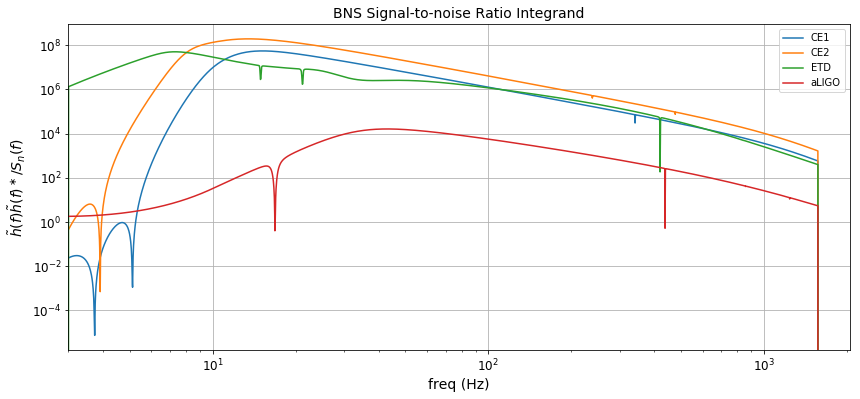

In [9]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.loglog(snr_integrand_ce1.sample_frequencies, snr_integrand_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, snr_integrand_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, snr_integrand_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, snr_integrand_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,2048])
plt.xlabel("freq (Hz)")
plt.ylabel(r"$\tilde{h}(f) \tilde{h}(f)^\ast / S_n(f)$")
plt.title("BNS Signal-to-noise Ratio Integrand")
plt.show()

In [10]:
norm_ce1 = np.trapz(snr_integrand_ce1[int(f_low / snr_integrand_ce1.delta_f + 1):], 
                    snr_integrand_ce1.sample_frequencies[int(f_low / snr_integrand_ce1.delta_f + 1):])
norm_ce2 = np.trapz(snr_integrand_ce2[int(f_low / snr_integrand_ce2.delta_f + 1):], 
                    snr_integrand_ce2.sample_frequencies[int(f_low / snr_integrand_ce2.delta_f + 1):])
norm_etd = np.trapz(snr_integrand_etd[int(f_low / snr_integrand_etd.delta_f + 1):], 
                    snr_integrand_etd.sample_frequencies[int(f_low / snr_integrand_etd.delta_f + 1):])
norm_aligo = np.trapz(snr_integrand_aligo[int(f_low / snr_integrand_aligo.delta_f + 1):-1], 
                    snr_integrand_aligo.sample_frequencies[int(f_low / snr_integrand_aligo.delta_f + 1):-1])
gc.collect()

12659

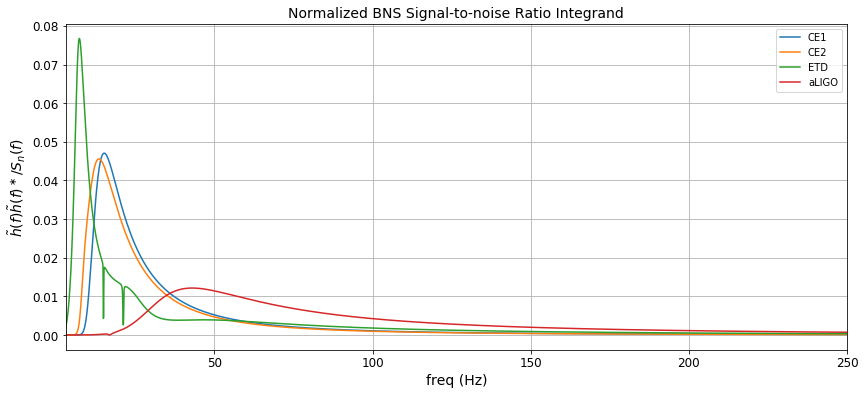

6218

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(snr_integrand_ce1.sample_frequencies, snr_integrand_ce1/norm_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, snr_integrand_ce2/norm_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, snr_integrand_etd/norm_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, snr_integrand_aligo/norm_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,250])
plt.xlabel("freq (Hz)")
plt.ylabel(r"$\tilde{h}(f) \tilde{h}(f)^\ast / S_n(f)$")
plt.title("Normalized BNS Signal-to-noise Ratio Integrand")
plt.show()
gc.collect()